In [43]:
import pandas as pd
import numpy as np
# load JS visualization code to notebook
shap.initjs()
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import stats
import matplotlib.pyplot as plt
# %matplotlib inline
import functions as f
from importlib import reload
reload(f)

<module 'functions' from 'C:\\Projects\\jupyter_notebook\\catboost\\functions.py'>

In [44]:
def plot_roc_curve(y1, y_pred1, gini1, y2, y_pred2, gini2):
    fpr1, tpr1, thresholds1 = roc_curve(y1, y_pred1)
    roc_auc1 = auc(fpr1, tpr1)
    fpr2, tpr2, thresholds2 = roc_curve(y2, y_pred2)
    roc_auc2 = auc(fpr2, tpr2)

    fig = plt.figure()
    plt.plot(fpr1, tpr1, 'b--', label='TRAIN: %s AUC = %0.4f, GINI = %0.2f' % ('Model: ', roc_auc1, gini1))
    plt.plot(fpr2, tpr2, 'r--', label='TEST: %s AUC = %0.4f, GINI = %0.2f' % ('Model: ', roc_auc2, gini2))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0, fontsize='small')
    plt.show()

In [45]:
df = pd.read_excel('data_erdni/rejects.xlsx', encoding='cp1251')

In [46]:
var_types = pd.read_csv('data_erdni/var_types_m2.csv', encoding='cp1251', sep=';')

In [47]:
df.head()

,UCDB_ID,Var__appl_00001,Var__appl_00002,Var__appl_00003,Var__appl_00004,Var__appl_00005,Var__appl_00006,Var__appl_00007,Var__appl_00008,Var__appl_00009,...,var2_dev_freq_bucket,var3_af_score_bucket,var4_amt_bucket,var5_stop_factors,ranking_scoring,cr_decision,cr_performance,target,migrej,Var_online_00101.1
0,1031453901,32,М,NaN,NaN,1,1,0,0,yes,...,1.0,2.0,4.0,0.0,-5.0,RJC,NPL90+,1,0,NaN
1,1031456018,44,Ж,NaN,NaN,0,1,0,1,yes,...,0.0,0.0,2.0,0.0,-1.0,APR,OK,0,0,NaN
2,1031456198,39,М,NaN,NaN,0,1,0,0,yes,...,1.0,1.0,4.0,0.0,-5.0,RJC,NPL90+,1,0,GroupedOtherLessGroups
3,1031459689,27,Ж,NaN,NaN,0,1,0,0,yes,...,1.0,1.0,4.0,0.0,-4.0,RJC,OK,0,0,NaN
4,1031482669,34,Ж,NaN,NaN,0,1,0,1,yes,...,1.0,0.0,4.0,0.0,-4.0,RJC,NPL90+,1,0,NaN


In [48]:
var_types.head()

,Variable,Discrete
0,AacSupport,False
1,AdditionalInfo,True
2,ALL_CLC,False
3,all_currdebt_ratio,False
4,all_hist_30dpd,False


In [49]:
all_features = list(var_types['Variable'])
text_features = list(var_types[var_types['Discrete'] == 1]['Variable'])
no_text_features = list(set(all_features).difference(text_features))

target = 'target'

In [50]:
for col in no_text_features:
    try:
        df[col] = df[col].map(lambda x: str(x).replace(',', '.') if ',' in str(x) else x)
        df[col] = df[col].astype(float)
    except:
        pass

In [51]:
df = df.fillna(-999)

In [52]:
df.head()

,UCDB_ID,Var__appl_00001,Var__appl_00002,Var__appl_00003,Var__appl_00004,Var__appl_00005,Var__appl_00006,Var__appl_00007,Var__appl_00008,Var__appl_00009,...,var2_dev_freq_bucket,var3_af_score_bucket,var4_amt_bucket,var5_stop_factors,ranking_scoring,cr_decision,cr_performance,target,migrej,Var_online_00101.1
0,1031453901,32.0,М,-1,-1,1.0,1.0,0.0,0.0,yes,...,1.0,2.0,4.0,0.0,-5.0,RJC,NPL90+,1,0,-1
1,1031456018,44.0,Ж,-1,-1,0.0,1.0,0.0,1.0,yes,...,0.0,0.0,2.0,0.0,-1.0,APR,OK,0,0,-1
2,1031456198,39.0,М,-1,-1,0.0,1.0,0.0,0.0,yes,...,1.0,1.0,4.0,0.0,-5.0,RJC,NPL90+,1,0,GroupedOtherLessGroups
3,1031459689,27.0,Ж,-1,-1,0.0,1.0,0.0,0.0,yes,...,1.0,1.0,4.0,0.0,-4.0,RJC,OK,0,0,-1
4,1031482669,34.0,Ж,-1,-1,0.0,1.0,0.0,1.0,yes,...,1.0,0.0,4.0,0.0,-4.0,RJC,NPL90+,1,0,-1


In [53]:
df = f.train_test_splits_1(df, target, 0.33, column_name='SampleType', train_name='train', test_name='test')

In [54]:
train = df[df['SampleType'] == 'train'].copy()
test = df[df['SampleType'] == 'test'].copy()
X_train = train.loc[:, all_features]
y_train = train[target]

X_test = test.loc[:, all_features]
y_test = test[target]

In [61]:
cat_features = []
for feature in all_features:
    if feature in text_features:
        cat_features.append(all_features.index(feature))
print(cat_features)

categorical_features_indices = list(np.where(pd.concat([X_train, X_test], axis=0).dtypes != np.float)[0])

[1, 19, 22, 23, 30, 39, 42, 44, 45, 46, 47, 49, 50, 66, 87, 88, 89, 90, 91, 95, 96, 97, 100, 101, 162, 163, 164, 168, 172, 173, 174, 229, 235, 252, 254, 255, 256, 261, 263, 264, 265, 266, 282, 288, 289, 290, 292, 296, 297, 298, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 724, 725, 732, 895, 916, 917, 918, 919, 920]


In [63]:
clf = CatBoostClassifier(random_seed=42, eval_metric="AUC", iterations=1000, learning_rate=0.01)

In [62]:
pool_train = Pool(X_train, y_train, cat_features=cat_features)

In [64]:
clf.fit(pool_train, eval_set=(X_test, y_test), plot=True, verbose_eval=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6326488	best: 0.6326488 (0)	total: 205ms	remaining: 3m 24s
1:	test: 0.6531315	best: 0.6531315 (1)	total: 417ms	remaining: 3m 27s
2:	test: 0.6638570	best: 0.6638570 (2)	total: 697ms	remaining: 3m 51s
3:	test: 0.6687215	best: 0.6687215 (3)	total: 894ms	remaining: 3m 42s
4:	test: 0.6704807	best: 0.6704807 (4)	total: 1.19s	remaining: 3m 57s
5:	test: 0.6713884	best: 0.6713884 (5)	total: 1.38s	remaining: 3m 49s
6:	test: 0.6731841	best: 0.6731841 (6)	total: 1.69s	remaining: 3m 59s
7:	test: 0.6746065	best: 0.6746065 (7)	total: 1.88s	remaining: 3m 52s
8:	test: 0.6756677	best: 0.6756677 (8)	total: 2.11s	remaining: 3m 52s
9:	test: 0.6775634	best: 0.6775634 (9)	total: 2.3s	remaining: 3m 47s
10:	test: 0.6766247	best: 0.6775634 (9)	total: 2.34s	remaining: 3m 30s
11:	test: 0.6762030	best: 0.6775634 (9)	total: 2.63s	remaining: 3m 36s
12:	test: 0.6768234	best: 0.6775634 (9)	total: 2.83s	remaining: 3m 35s
13:	test: 0.6766001	best: 0.6775634 (9)	total: 3.14s	remaining: 3m 41s
14:	test: 0.67708

114:	test: 0.6889586	best: 0.6891402 (113)	total: 25.1s	remaining: 3m 13s
115:	test: 0.6891592	best: 0.6891592 (115)	total: 25.3s	remaining: 3m 12s
116:	test: 0.6891366	best: 0.6891592 (115)	total: 25.6s	remaining: 3m 13s
117:	test: 0.6892487	best: 0.6892487 (117)	total: 25.7s	remaining: 3m 11s
118:	test: 0.6892937	best: 0.6892937 (118)	total: 25.8s	remaining: 3m 11s
119:	test: 0.6895384	best: 0.6895384 (119)	total: 26.2s	remaining: 3m 11s
120:	test: 0.6895373	best: 0.6895384 (119)	total: 26.3s	remaining: 3m 11s
121:	test: 0.6894265	best: 0.6895384 (119)	total: 26.6s	remaining: 3m 11s
122:	test: 0.6897352	best: 0.6897352 (122)	total: 26.8s	remaining: 3m 11s
123:	test: 0.6896757	best: 0.6897352 (122)	total: 27.1s	remaining: 3m 11s
124:	test: 0.6898959	best: 0.6898959 (124)	total: 27.3s	remaining: 3m 11s
125:	test: 0.6899833	best: 0.6899833 (125)	total: 27.6s	remaining: 3m 11s
126:	test: 0.6900135	best: 0.6900135 (126)	total: 27.8s	remaining: 3m 10s
127:	test: 0.6900930	best: 0.6900930 (

227:	test: 0.6976533	best: 0.6976533 (227)	total: 51.4s	remaining: 2m 54s
228:	test: 0.6978291	best: 0.6978291 (228)	total: 51.6s	remaining: 2m 53s
229:	test: 0.6978496	best: 0.6978496 (229)	total: 51.9s	remaining: 2m 53s
230:	test: 0.6980454	best: 0.6980454 (230)	total: 52.1s	remaining: 2m 53s
231:	test: 0.6980112	best: 0.6980454 (230)	total: 52.4s	remaining: 2m 53s
232:	test: 0.6981627	best: 0.6981627 (232)	total: 52.6s	remaining: 2m 53s
233:	test: 0.6983833	best: 0.6983833 (233)	total: 52.9s	remaining: 2m 53s
234:	test: 0.6985402	best: 0.6985402 (234)	total: 53s	remaining: 2m 52s
235:	test: 0.6985519	best: 0.6985519 (235)	total: 53.2s	remaining: 2m 52s
236:	test: 0.6986644	best: 0.6986644 (236)	total: 53.5s	remaining: 2m 52s
237:	test: 0.6987331	best: 0.6987331 (237)	total: 53.6s	remaining: 2m 51s
238:	test: 0.6986774	best: 0.6987331 (237)	total: 54s	remaining: 2m 51s
239:	test: 0.6987522	best: 0.6987522 (239)	total: 54.2s	remaining: 2m 51s
240:	test: 0.6987956	best: 0.6987956 (240)

338:	test: 0.7025633	best: 0.7025633 (338)	total: 1m 15s	remaining: 2m 28s
339:	test: 0.7025683	best: 0.7025683 (339)	total: 1m 16s	remaining: 2m 27s
340:	test: 0.7025336	best: 0.7025683 (339)	total: 1m 16s	remaining: 2m 27s
341:	test: 0.7025662	best: 0.7025683 (339)	total: 1m 16s	remaining: 2m 27s
342:	test: 0.7025801	best: 0.7025801 (342)	total: 1m 16s	remaining: 2m 27s
343:	test: 0.7025981	best: 0.7025981 (343)	total: 1m 16s	remaining: 2m 26s
344:	test: 0.7026453	best: 0.7026453 (344)	total: 1m 17s	remaining: 2m 26s
345:	test: 0.7027268	best: 0.7027268 (345)	total: 1m 17s	remaining: 2m 26s
346:	test: 0.7027428	best: 0.7027428 (346)	total: 1m 17s	remaining: 2m 25s
347:	test: 0.7027779	best: 0.7027779 (347)	total: 1m 17s	remaining: 2m 25s
348:	test: 0.7028381	best: 0.7028381 (348)	total: 1m 17s	remaining: 2m 25s
349:	test: 0.7028409	best: 0.7028409 (349)	total: 1m 18s	remaining: 2m 25s
350:	test: 0.7029763	best: 0.7029763 (350)	total: 1m 18s	remaining: 2m 25s
351:	test: 0.7030623	best

448:	test: 0.7056844	best: 0.7056871 (447)	total: 1m 39s	remaining: 2m 1s
449:	test: 0.7056724	best: 0.7056871 (447)	total: 1m 39s	remaining: 2m 1s
450:	test: 0.7057199	best: 0.7057199 (450)	total: 1m 39s	remaining: 2m 1s
451:	test: 0.7058117	best: 0.7058117 (451)	total: 1m 39s	remaining: 2m 1s
452:	test: 0.7058876	best: 0.7058876 (452)	total: 1m 40s	remaining: 2m 1s
453:	test: 0.7058849	best: 0.7058876 (452)	total: 1m 40s	remaining: 2m
454:	test: 0.7059069	best: 0.7059069 (454)	total: 1m 40s	remaining: 2m
455:	test: 0.7059073	best: 0.7059073 (455)	total: 1m 40s	remaining: 2m
456:	test: 0.7059304	best: 0.7059304 (456)	total: 1m 41s	remaining: 2m
457:	test: 0.7059469	best: 0.7059469 (457)	total: 1m 41s	remaining: 2m
458:	test: 0.7059440	best: 0.7059469 (457)	total: 1m 41s	remaining: 1m 59s
459:	test: 0.7059247	best: 0.7059469 (457)	total: 1m 41s	remaining: 1m 59s
460:	test: 0.7059432	best: 0.7059469 (457)	total: 1m 42s	remaining: 1m 59s
461:	test: 0.7059406	best: 0.7059469 (457)	total: 

558:	test: 0.7079454	best: 0.7079933 (556)	total: 2m 2s	remaining: 1m 36s
559:	test: 0.7079784	best: 0.7079933 (556)	total: 2m 2s	remaining: 1m 36s
560:	test: 0.7079688	best: 0.7079933 (556)	total: 2m 2s	remaining: 1m 36s
561:	test: 0.7079872	best: 0.7079933 (556)	total: 2m 2s	remaining: 1m 35s
562:	test: 0.7080234	best: 0.7080234 (562)	total: 2m 3s	remaining: 1m 35s
563:	test: 0.7080627	best: 0.7080627 (563)	total: 2m 3s	remaining: 1m 35s
564:	test: 0.7080768	best: 0.7080768 (564)	total: 2m 3s	remaining: 1m 35s
565:	test: 0.7080923	best: 0.7080923 (565)	total: 2m 3s	remaining: 1m 34s
566:	test: 0.7081154	best: 0.7081154 (566)	total: 2m 3s	remaining: 1m 34s
567:	test: 0.7081204	best: 0.7081204 (567)	total: 2m 4s	remaining: 1m 34s
568:	test: 0.7081360	best: 0.7081360 (568)	total: 2m 4s	remaining: 1m 34s
569:	test: 0.7081335	best: 0.7081360 (568)	total: 2m 4s	remaining: 1m 33s
570:	test: 0.7081884	best: 0.7081884 (570)	total: 2m 4s	remaining: 1m 33s
571:	test: 0.7082069	best: 0.7082069 (

668:	test: 0.7099311	best: 0.7099311 (668)	total: 2m 25s	remaining: 1m 11s
669:	test: 0.7099293	best: 0.7099311 (668)	total: 2m 25s	remaining: 1m 11s
670:	test: 0.7099452	best: 0.7099452 (670)	total: 2m 25s	remaining: 1m 11s
671:	test: 0.7099442	best: 0.7099452 (670)	total: 2m 26s	remaining: 1m 11s
672:	test: 0.7099226	best: 0.7099452 (670)	total: 2m 26s	remaining: 1m 11s
673:	test: 0.7099428	best: 0.7099452 (670)	total: 2m 26s	remaining: 1m 10s
674:	test: 0.7099359	best: 0.7099452 (670)	total: 2m 26s	remaining: 1m 10s
675:	test: 0.7099625	best: 0.7099625 (675)	total: 2m 27s	remaining: 1m 10s
676:	test: 0.7099721	best: 0.7099721 (676)	total: 2m 27s	remaining: 1m 10s
677:	test: 0.7100023	best: 0.7100023 (677)	total: 2m 27s	remaining: 1m 10s
678:	test: 0.7100213	best: 0.7100213 (678)	total: 2m 27s	remaining: 1m 9s
679:	test: 0.7099931	best: 0.7100213 (678)	total: 2m 28s	remaining: 1m 9s
680:	test: 0.7100087	best: 0.7100213 (678)	total: 2m 28s	remaining: 1m 9s
681:	test: 0.7100304	best: 0

779:	test: 0.7114841	best: 0.7114841 (779)	total: 2m 46s	remaining: 47s
780:	test: 0.7115841	best: 0.7115841 (780)	total: 2m 46s	remaining: 46.7s
781:	test: 0.7115917	best: 0.7115917 (781)	total: 2m 46s	remaining: 46.5s
782:	test: 0.7116229	best: 0.7116229 (782)	total: 2m 47s	remaining: 46.3s
783:	test: 0.7116227	best: 0.7116229 (782)	total: 2m 47s	remaining: 46s
784:	test: 0.7116347	best: 0.7116347 (784)	total: 2m 47s	remaining: 45.8s
785:	test: 0.7116789	best: 0.7116789 (785)	total: 2m 47s	remaining: 45.6s
786:	test: 0.7117062	best: 0.7117062 (786)	total: 2m 47s	remaining: 45.4s
787:	test: 0.7117004	best: 0.7117062 (786)	total: 2m 48s	remaining: 45.2s
788:	test: 0.7117230	best: 0.7117230 (788)	total: 2m 48s	remaining: 45s
789:	test: 0.7117540	best: 0.7117540 (789)	total: 2m 48s	remaining: 44.8s
790:	test: 0.7118113	best: 0.7118113 (790)	total: 2m 48s	remaining: 44.6s
791:	test: 0.7118119	best: 0.7118119 (791)	total: 2m 48s	remaining: 44.4s
792:	test: 0.7117963	best: 0.7118119 (791)	t

891:	test: 0.7128535	best: 0.7128535 (891)	total: 3m 9s	remaining: 22.9s
892:	test: 0.7128938	best: 0.7128938 (892)	total: 3m 9s	remaining: 22.7s
893:	test: 0.7128999	best: 0.7128999 (893)	total: 3m 9s	remaining: 22.5s
894:	test: 0.7129218	best: 0.7129218 (894)	total: 3m 9s	remaining: 22.3s
895:	test: 0.7129474	best: 0.7129474 (895)	total: 3m 10s	remaining: 22.1s
896:	test: 0.7129495	best: 0.7129495 (896)	total: 3m 10s	remaining: 21.8s
897:	test: 0.7129509	best: 0.7129509 (897)	total: 3m 10s	remaining: 21.6s
898:	test: 0.7129522	best: 0.7129522 (898)	total: 3m 10s	remaining: 21.4s
899:	test: 0.7129780	best: 0.7129780 (899)	total: 3m 10s	remaining: 21.2s
900:	test: 0.7129877	best: 0.7129877 (900)	total: 3m 10s	remaining: 21s
901:	test: 0.7130029	best: 0.7130029 (901)	total: 3m 11s	remaining: 20.8s
902:	test: 0.7130104	best: 0.7130104 (902)	total: 3m 11s	remaining: 20.6s
903:	test: 0.7130585	best: 0.7130585 (903)	total: 3m 11s	remaining: 20.3s
904:	test: 0.7130812	best: 0.7130812 (904)	t

In [65]:
X_train['Prop'] = clf.predict(X_train, prediction_type="Probability")[:, 1]
X_test['Prop'] = clf.predict(X_test, prediction_type="Probability")[:, 1]

In [66]:
gini_train = 2 * roc_auc_score(y_train, X_train['Prop']) - 1
gini_test = 2 * roc_auc_score(y_test, X_test['Prop']) - 1
print('gini train = %s, gini test = %s' % (gini_train, gini_test))

gini train = 0.469532105239012, gini test = 0.4278121624601492


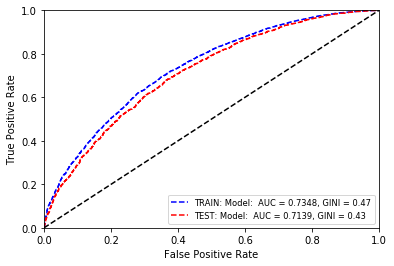

In [67]:
plot_roc_curve(y_train, X_train['Prop'], gini_train, y_test, X_test['Prop'], gini_test)

In [76]:
data = pd.DataFrame({'Variable': all_features})
data['fi_default'] = clf.feature_importances_
# data['fi_fi'] = clf.get_feature_importance(pool_train, fstr_type='FeatureImportance')
# data['fi_shv'] = clf.get_feature_importance(pool_train, fstr_type='ShapValues')
# data['fi_int'] = clf.get_feature_importance(pool_train, fstr_type='Interaction')
data = data.sort_values(by='fi_default', ascending=False)

data.head()
# data.to_excel('data_erdni/fi_0.xlsx', index=False)

all_features_2 = list(data.head(200)['Variable'])
# print(all_features_2)

## Top 200 variables

In [78]:
X_train_2 = train.loc[:, all_features_2]
y_train_2 = train[target]

X_test_2 = test.loc[:, all_features_2]
y_test_2 = test[target]

cat_features_2 = list(np.where(pd.concat([X_train_2, X_test_2], axis=0).dtypes != np.float)[0])
cat_features_2

[38,
 39,
 41,
 44,
 50,
 58,
 67,
 69,
 73,
 76,
 92,
 94,
 95,
 96,
 100,
 106,
 134,
 146,
 153,
 157,
 169,
 173,
 186,
 191]

In [81]:
pool_train_2 = Pool(X_train_2, y_train_2, cat_features=cat_features_2)

In [83]:
clf2 = CatBoostClassifier(random_seed=42, eval_metric="AUC", iterations=1000, learning_rate=0.01)
clf2.fit(pool_train_2, eval_set=(X_test_2, y_test_2), plot=True, verbose_eval=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6429643	best: 0.6429643 (0)	total: 86ms	remaining: 1m 25s
1:	test: 0.6520011	best: 0.6520011 (1)	total: 194ms	remaining: 1m 36s
2:	test: 0.6645156	best: 0.6645156 (2)	total: 272ms	remaining: 1m 30s
3:	test: 0.6634950	best: 0.6645156 (2)	total: 367ms	remaining: 1m 31s
4:	test: 0.6647893	best: 0.6647893 (4)	total: 441ms	remaining: 1m 27s
5:	test: 0.6701472	best: 0.6701472 (5)	total: 533ms	remaining: 1m 28s
6:	test: 0.6743606	best: 0.6743606 (6)	total: 633ms	remaining: 1m 29s
7:	test: 0.6725629	best: 0.6743606 (6)	total: 693ms	remaining: 1m 25s
8:	test: 0.6743436	best: 0.6743606 (6)	total: 784ms	remaining: 1m 26s
9:	test: 0.6760447	best: 0.6760447 (9)	total: 888ms	remaining: 1m 27s
10:	test: 0.6777866	best: 0.6777866 (10)	total: 993ms	remaining: 1m 29s
11:	test: 0.6791932	best: 0.6791932 (11)	total: 1.07s	remaining: 1m 28s
12:	test: 0.6807533	best: 0.6807533 (12)	total: 1.18s	remaining: 1m 29s
13:	test: 0.6812451	best: 0.6812451 (13)	total: 1.28s	remaining: 1m 30s
14:	test: 0.6

114:	test: 0.6959156	best: 0.6959315 (113)	total: 11s	remaining: 1m 24s
115:	test: 0.6960224	best: 0.6960224 (115)	total: 11.1s	remaining: 1m 24s
116:	test: 0.6962748	best: 0.6962748 (116)	total: 11.2s	remaining: 1m 24s
117:	test: 0.6963756	best: 0.6963756 (117)	total: 11.3s	remaining: 1m 24s
118:	test: 0.6963726	best: 0.6963756 (117)	total: 11.4s	remaining: 1m 24s
119:	test: 0.6964664	best: 0.6964664 (119)	total: 11.5s	remaining: 1m 24s
120:	test: 0.6966639	best: 0.6966639 (120)	total: 11.6s	remaining: 1m 24s
121:	test: 0.6966802	best: 0.6966802 (121)	total: 11.7s	remaining: 1m 24s
122:	test: 0.6967559	best: 0.6967559 (122)	total: 11.8s	remaining: 1m 23s
123:	test: 0.6967102	best: 0.6967559 (122)	total: 11.8s	remaining: 1m 23s
124:	test: 0.6967387	best: 0.6967559 (122)	total: 11.9s	remaining: 1m 23s
125:	test: 0.6966490	best: 0.6967559 (122)	total: 12s	remaining: 1m 23s
126:	test: 0.6966521	best: 0.6967559 (122)	total: 12.1s	remaining: 1m 23s
127:	test: 0.6967919	best: 0.6967919 (127)

226:	test: 0.7034216	best: 0.7034216 (226)	total: 21.9s	remaining: 1m 14s
227:	test: 0.7034252	best: 0.7034252 (227)	total: 22s	remaining: 1m 14s
228:	test: 0.7034778	best: 0.7034778 (228)	total: 22.1s	remaining: 1m 14s
229:	test: 0.7035551	best: 0.7035551 (229)	total: 22.2s	remaining: 1m 14s
230:	test: 0.7035426	best: 0.7035551 (229)	total: 22.2s	remaining: 1m 14s
231:	test: 0.7034915	best: 0.7035551 (229)	total: 22.3s	remaining: 1m 13s
232:	test: 0.7035071	best: 0.7035551 (229)	total: 22.4s	remaining: 1m 13s
233:	test: 0.7035964	best: 0.7035964 (233)	total: 22.5s	remaining: 1m 13s
234:	test: 0.7037045	best: 0.7037045 (234)	total: 22.6s	remaining: 1m 13s
235:	test: 0.7037185	best: 0.7037185 (235)	total: 22.7s	remaining: 1m 13s
236:	test: 0.7037222	best: 0.7037222 (236)	total: 22.8s	remaining: 1m 13s
237:	test: 0.7037162	best: 0.7037222 (236)	total: 23s	remaining: 1m 13s
238:	test: 0.7037882	best: 0.7037882 (238)	total: 23.1s	remaining: 1m 13s
239:	test: 0.7038407	best: 0.7038407 (239)

338:	test: 0.7075223	best: 0.7075223 (338)	total: 32s	remaining: 1m 2s
339:	test: 0.7075445	best: 0.7075445 (339)	total: 32.1s	remaining: 1m 2s
340:	test: 0.7075928	best: 0.7075928 (340)	total: 32.2s	remaining: 1m 2s
341:	test: 0.7076799	best: 0.7076799 (341)	total: 32.3s	remaining: 1m 2s
342:	test: 0.7077232	best: 0.7077232 (342)	total: 32.4s	remaining: 1m 2s
343:	test: 0.7077886	best: 0.7077886 (343)	total: 32.5s	remaining: 1m 1s
344:	test: 0.7078039	best: 0.7078039 (344)	total: 32.6s	remaining: 1m 1s
345:	test: 0.7078135	best: 0.7078135 (345)	total: 32.7s	remaining: 1m 1s
346:	test: 0.7078432	best: 0.7078432 (346)	total: 32.8s	remaining: 1m 1s
347:	test: 0.7078760	best: 0.7078760 (347)	total: 32.9s	remaining: 1m 1s
348:	test: 0.7078743	best: 0.7078760 (347)	total: 32.9s	remaining: 1m 1s
349:	test: 0.7078758	best: 0.7078760 (347)	total: 33s	remaining: 1m 1s
350:	test: 0.7078668	best: 0.7078760 (347)	total: 33.1s	remaining: 1m 1s
351:	test: 0.7079031	best: 0.7079031 (351)	total: 33.2s

452:	test: 0.7100999	best: 0.7100999 (452)	total: 42.2s	remaining: 51s
453:	test: 0.7101218	best: 0.7101218 (453)	total: 42.3s	remaining: 50.9s
454:	test: 0.7101306	best: 0.7101306 (454)	total: 42.4s	remaining: 50.8s
455:	test: 0.7101492	best: 0.7101492 (455)	total: 42.5s	remaining: 50.7s
456:	test: 0.7101658	best: 0.7101658 (456)	total: 42.6s	remaining: 50.6s
457:	test: 0.7101371	best: 0.7101658 (456)	total: 42.7s	remaining: 50.5s
458:	test: 0.7101624	best: 0.7101658 (456)	total: 42.7s	remaining: 50.4s
459:	test: 0.7102008	best: 0.7102008 (459)	total: 42.8s	remaining: 50.3s
460:	test: 0.7102482	best: 0.7102482 (460)	total: 42.9s	remaining: 50.2s
461:	test: 0.7102828	best: 0.7102828 (461)	total: 43s	remaining: 50.1s
462:	test: 0.7103101	best: 0.7103101 (462)	total: 43.1s	remaining: 50s
463:	test: 0.7103549	best: 0.7103549 (463)	total: 43.3s	remaining: 50s
464:	test: 0.7103885	best: 0.7103885 (464)	total: 43.4s	remaining: 49.9s
465:	test: 0.7103919	best: 0.7103919 (465)	total: 43.4s	rem

565:	test: 0.7119286	best: 0.7119425 (564)	total: 52.5s	remaining: 40.3s
566:	test: 0.7119466	best: 0.7119466 (566)	total: 52.6s	remaining: 40.2s
567:	test: 0.7119455	best: 0.7119466 (566)	total: 52.7s	remaining: 40.1s
568:	test: 0.7119653	best: 0.7119653 (568)	total: 52.7s	remaining: 40s
569:	test: 0.7119886	best: 0.7119886 (569)	total: 52.8s	remaining: 39.9s
570:	test: 0.7120002	best: 0.7120002 (570)	total: 52.9s	remaining: 39.8s
571:	test: 0.7120234	best: 0.7120234 (571)	total: 53s	remaining: 39.7s
572:	test: 0.7120150	best: 0.7120234 (571)	total: 53.1s	remaining: 39.6s
573:	test: 0.7120053	best: 0.7120234 (571)	total: 53.2s	remaining: 39.5s
574:	test: 0.7120227	best: 0.7120234 (571)	total: 53.2s	remaining: 39.4s
575:	test: 0.7120398	best: 0.7120398 (575)	total: 53.3s	remaining: 39.2s
576:	test: 0.7120409	best: 0.7120409 (576)	total: 53.4s	remaining: 39.1s
577:	test: 0.7120439	best: 0.7120439 (577)	total: 53.4s	remaining: 39s
578:	test: 0.7120574	best: 0.7120574 (578)	total: 53.5s	r

679:	test: 0.7135737	best: 0.7135789 (676)	total: 1m 2s	remaining: 29.5s
680:	test: 0.7135914	best: 0.7135914 (680)	total: 1m 2s	remaining: 29.4s
681:	test: 0.7136085	best: 0.7136085 (681)	total: 1m 2s	remaining: 29.3s
682:	test: 0.7136342	best: 0.7136342 (682)	total: 1m 3s	remaining: 29.3s
683:	test: 0.7136592	best: 0.7136592 (683)	total: 1m 3s	remaining: 29.2s
684:	test: 0.7136766	best: 0.7136766 (684)	total: 1m 3s	remaining: 29.1s
685:	test: 0.7136766	best: 0.7136766 (684)	total: 1m 3s	remaining: 28.9s
686:	test: 0.7136980	best: 0.7136980 (686)	total: 1m 3s	remaining: 28.9s
687:	test: 0.7136980	best: 0.7136980 (686)	total: 1m 3s	remaining: 28.7s
688:	test: 0.7136991	best: 0.7136991 (688)	total: 1m 3s	remaining: 28.6s
689:	test: 0.7136930	best: 0.7136991 (688)	total: 1m 3s	remaining: 28.5s
690:	test: 0.7137024	best: 0.7137024 (690)	total: 1m 3s	remaining: 28.4s
691:	test: 0.7137284	best: 0.7137284 (691)	total: 1m 3s	remaining: 28.3s
692:	test: 0.7137360	best: 0.7137360 (692)	total: 1

792:	test: 0.7149110	best: 0.7149156 (790)	total: 1m 11s	remaining: 18.8s
793:	test: 0.7149323	best: 0.7149323 (793)	total: 1m 12s	remaining: 18.7s
794:	test: 0.7149228	best: 0.7149323 (793)	total: 1m 12s	remaining: 18.6s
795:	test: 0.7149170	best: 0.7149323 (793)	total: 1m 12s	remaining: 18.5s
796:	test: 0.7149249	best: 0.7149323 (793)	total: 1m 12s	remaining: 18.4s
797:	test: 0.7149258	best: 0.7149323 (793)	total: 1m 12s	remaining: 18.3s
798:	test: 0.7149605	best: 0.7149605 (798)	total: 1m 12s	remaining: 18.2s
799:	test: 0.7149539	best: 0.7149605 (798)	total: 1m 12s	remaining: 18.1s
800:	test: 0.7149768	best: 0.7149768 (800)	total: 1m 12s	remaining: 18s
801:	test: 0.7150242	best: 0.7150242 (801)	total: 1m 12s	remaining: 18s
802:	test: 0.7150470	best: 0.7150470 (802)	total: 1m 12s	remaining: 17.9s
803:	test: 0.7150113	best: 0.7150470 (802)	total: 1m 12s	remaining: 17.8s
804:	test: 0.7149910	best: 0.7150470 (802)	total: 1m 13s	remaining: 17.7s
805:	test: 0.7150216	best: 0.7150470 (802)

904:	test: 0.7161788	best: 0.7161788 (904)	total: 1m 21s	remaining: 8.59s
905:	test: 0.7161872	best: 0.7161872 (905)	total: 1m 21s	remaining: 8.5s
906:	test: 0.7161904	best: 0.7161904 (906)	total: 1m 22s	remaining: 8.41s
907:	test: 0.7162292	best: 0.7162292 (907)	total: 1m 22s	remaining: 8.32s
908:	test: 0.7162582	best: 0.7162582 (908)	total: 1m 22s	remaining: 8.23s
909:	test: 0.7162599	best: 0.7162599 (909)	total: 1m 22s	remaining: 8.14s
910:	test: 0.7162749	best: 0.7162749 (910)	total: 1m 22s	remaining: 8.05s
911:	test: 0.7162653	best: 0.7162749 (910)	total: 1m 22s	remaining: 7.96s
912:	test: 0.7162817	best: 0.7162817 (912)	total: 1m 22s	remaining: 7.87s
913:	test: 0.7162925	best: 0.7162925 (913)	total: 1m 22s	remaining: 7.78s
914:	test: 0.7162763	best: 0.7162925 (913)	total: 1m 22s	remaining: 7.69s
915:	test: 0.7162849	best: 0.7162925 (913)	total: 1m 22s	remaining: 7.6s
916:	test: 0.7162849	best: 0.7162925 (913)	total: 1m 22s	remaining: 7.51s
917:	test: 0.7163123	best: 0.7163123 (91

gini train = 0.4809757897178153, gini test = 0.43393188842918073


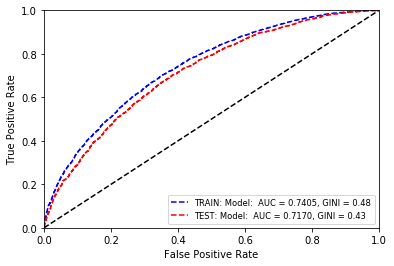

In [85]:
X_train_2['Prop'] = clf2.predict(X_train_2, prediction_type="Probability")[:, 1]
X_test_2['Prop'] = clf2.predict(X_test_2, prediction_type="Probability")[:, 1]

gini_train_2 = 2 * roc_auc_score(y_train_2, X_train_2['Prop']) - 1
gini_test_2 = 2 * roc_auc_score(y_test_2, X_test_2['Prop']) - 1
print('gini train = %s, gini test = %s' % (gini_train_2, gini_test_2))

plot_roc_curve(y_train_2, X_train_2['Prop'], gini_train_2, y_test_2, X_test_2['Prop'], gini_test_2)

In [86]:
data2 = pd.DataFrame({'Variable': all_features_2})
data2['fi_default'] = clf2.feature_importances_
# data['fi_fi'] = clf.get_feature_importance(pool_train, fstr_type='FeatureImportance')
# data['fi_shv'] = clf.get_feature_importance(pool_train, fstr_type='ShapValues')
# data['fi_int'] = clf.get_feature_importance(pool_train, fstr_type='Interaction')
data2 = data2.sort_values(by='fi_default', ascending=False)

data2.head()
# data2.to_excel('data_erdni/fi_2.xlsx', index=False)

# all_features_3 = list(data2.head(200)['Variable'])

In [87]:
all_features_3 = [  
    'var_03_queries_1m',
'scorecard_13_14',
'MIGCREDIT_SCORE',
'Var__appl_00059',
'var_03_queries_3m',
'var_03_queries_2m',
'var_03_queries_6m',
'var_03_queries_14d',
'Var_online_00011',
'var_03_queries_24m',
'var_03_queries_12m',
'var_07_dpd_1m',
'Var_online_00014',
'Var_online_00100',
'var_01_queries_1m',
'Var_00408',
'Var__appl_00055',
'all_satis_paidoff',
'var_03_queries_36m',
'Var_00410',
'Var_00254',
'var_01_queries_2m',
'Var_00409',
'var_07_dpd_36m',
'Var_00404',
'var_07_dpd_60m',
'var_07_dpd_24m',
'Var_online_00017',
'var_07_dpd_3m',
'var_07_dpd_2m',
'Var_00026',
'LIFETIME_BIN',
'Var_online_00101',
'Var_00067',
'var_07_dpd_12m',
'var_07_dpd_6m',
'Var_online_00018',
'Var_online_00103',
'Var_00363',
'Var_00022',
'Var_00066',
'var_01_queries_3m',
'Var_00362',
'Var__appl_00036',
'Var_online_00081',
'var_03_queries_7d',
'Var_00040',
'BLOCK_DUR',
'Var_00239',
'Var_00219',
'Var_00121',
'Var_00052',
'Var__appl_00019',
'Var_00068',
'Var_00003',
'Var_00253'

]

In [110]:
len(all_features_3)

56

In [88]:
X_train_3 = train.loc[:, all_features_3]
y_train_3 = train[target]

X_test_3 = test.loc[:, all_features_3]
y_test_3 = test[target]

cat_features_3 = list(np.where(pd.concat([X_train_3, X_test_3], axis=0).dtypes != np.float)[0])
cat_features_3

[32, 37, 43, 49]

In [89]:
pool_train_3 = Pool(X_train_3, y_train_3, cat_features=cat_features_3)
clf3 = CatBoostClassifier(random_seed=42, eval_metric="AUC", iterations=1000, learning_rate=0.01)
clf3.fit(pool_train_3, eval_set=(X_test_3, y_test_3), plot=True, verbose_eval=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6426890	best: 0.6426890 (0)	total: 38.7ms	remaining: 38.7s
1:	test: 0.6600545	best: 0.6600545 (1)	total: 73.7ms	remaining: 36.8s
2:	test: 0.6691024	best: 0.6691024 (2)	total: 120ms	remaining: 39.9s
3:	test: 0.6703045	best: 0.6703045 (3)	total: 158ms	remaining: 39.3s
4:	test: 0.6711312	best: 0.6711312 (4)	total: 204ms	remaining: 40.6s
5:	test: 0.6760169	best: 0.6760169 (5)	total: 240ms	remaining: 39.7s
6:	test: 0.6784469	best: 0.6784469 (6)	total: 287ms	remaining: 40.7s
7:	test: 0.6792512	best: 0.6792512 (7)	total: 325ms	remaining: 40.3s
8:	test: 0.6773605	best: 0.6792512 (7)	total: 373ms	remaining: 41.1s
9:	test: 0.6773005	best: 0.6792512 (7)	total: 410ms	remaining: 40.5s
10:	test: 0.6779091	best: 0.6792512 (7)	total: 456ms	remaining: 41s
11:	test: 0.6788073	best: 0.6792512 (7)	total: 494ms	remaining: 40.7s
12:	test: 0.6790452	best: 0.6792512 (7)	total: 539ms	remaining: 41s
13:	test: 0.6791801	best: 0.6792512 (7)	total: 578ms	remaining: 40.7s
14:	test: 0.6787554	best: 0.6792

117:	test: 0.6863884	best: 0.6863884 (117)	total: 4.96s	remaining: 37.1s
118:	test: 0.6863247	best: 0.6863884 (117)	total: 5s	remaining: 37s
119:	test: 0.6865334	best: 0.6865334 (119)	total: 5.06s	remaining: 37.1s
120:	test: 0.6865810	best: 0.6865810 (120)	total: 5.09s	remaining: 37s
121:	test: 0.6866114	best: 0.6866114 (121)	total: 5.14s	remaining: 37s
122:	test: 0.6865619	best: 0.6866114 (121)	total: 5.18s	remaining: 37s
123:	test: 0.6866398	best: 0.6866398 (123)	total: 5.23s	remaining: 36.9s
124:	test: 0.6866471	best: 0.6866471 (124)	total: 5.26s	remaining: 36.9s
125:	test: 0.6867375	best: 0.6867375 (125)	total: 5.32s	remaining: 36.9s
126:	test: 0.6867250	best: 0.6867375 (125)	total: 5.36s	remaining: 36.8s
127:	test: 0.6868108	best: 0.6868108 (127)	total: 5.4s	remaining: 36.8s
128:	test: 0.6868224	best: 0.6868224 (128)	total: 5.44s	remaining: 36.8s
129:	test: 0.6868277	best: 0.6868277 (129)	total: 5.49s	remaining: 36.8s
130:	test: 0.6869290	best: 0.6869290 (130)	total: 5.52s	remaini

230:	test: 0.6923423	best: 0.6923423 (230)	total: 9.67s	remaining: 32.2s
231:	test: 0.6923406	best: 0.6923423 (230)	total: 9.7s	remaining: 32.1s
232:	test: 0.6924312	best: 0.6924312 (232)	total: 9.75s	remaining: 32.1s
233:	test: 0.6925241	best: 0.6925241 (233)	total: 9.78s	remaining: 32s
234:	test: 0.6925553	best: 0.6925553 (234)	total: 9.83s	remaining: 32s
235:	test: 0.6926102	best: 0.6926102 (235)	total: 9.87s	remaining: 31.9s
236:	test: 0.6927036	best: 0.6927036 (236)	total: 9.92s	remaining: 31.9s
237:	test: 0.6927050	best: 0.6927050 (237)	total: 9.96s	remaining: 31.9s
238:	test: 0.6927189	best: 0.6927189 (238)	total: 10s	remaining: 31.8s
239:	test: 0.6927676	best: 0.6927676 (239)	total: 10s	remaining: 31.8s
240:	test: 0.6927442	best: 0.6927676 (239)	total: 10.1s	remaining: 31.8s
241:	test: 0.6927574	best: 0.6927676 (239)	total: 10.1s	remaining: 31.7s
242:	test: 0.6928414	best: 0.6928414 (242)	total: 10.2s	remaining: 31.7s
243:	test: 0.6929635	best: 0.6929635 (243)	total: 10.2s	rema

343:	test: 0.6955567	best: 0.6955624 (342)	total: 14.1s	remaining: 26.9s
344:	test: 0.6955700	best: 0.6955700 (344)	total: 14.1s	remaining: 26.9s
345:	test: 0.6956060	best: 0.6956060 (345)	total: 14.2s	remaining: 26.8s
346:	test: 0.6956200	best: 0.6956200 (346)	total: 14.2s	remaining: 26.8s
347:	test: 0.6956808	best: 0.6956808 (347)	total: 14.3s	remaining: 26.8s
348:	test: 0.6957421	best: 0.6957421 (348)	total: 14.3s	remaining: 26.7s
349:	test: 0.6957534	best: 0.6957534 (349)	total: 14.4s	remaining: 26.7s
350:	test: 0.6957498	best: 0.6957534 (349)	total: 14.4s	remaining: 26.6s
351:	test: 0.6957479	best: 0.6957534 (349)	total: 14.4s	remaining: 26.6s
352:	test: 0.6957777	best: 0.6957777 (352)	total: 14.5s	remaining: 26.6s
353:	test: 0.6957769	best: 0.6957777 (352)	total: 14.5s	remaining: 26.5s
354:	test: 0.6958141	best: 0.6958141 (354)	total: 14.6s	remaining: 26.4s
355:	test: 0.6958350	best: 0.6958350 (355)	total: 14.6s	remaining: 26.4s
356:	test: 0.6958973	best: 0.6958973 (356)	total: 1

456:	test: 0.6976330	best: 0.6976330 (456)	total: 18.6s	remaining: 22.1s
457:	test: 0.6976656	best: 0.6976656 (457)	total: 18.7s	remaining: 22.1s
458:	test: 0.6977762	best: 0.6977762 (458)	total: 18.7s	remaining: 22.1s
459:	test: 0.6978014	best: 0.6978014 (459)	total: 18.8s	remaining: 22s
460:	test: 0.6978200	best: 0.6978200 (460)	total: 18.8s	remaining: 22s
461:	test: 0.6978044	best: 0.6978200 (460)	total: 18.8s	remaining: 21.9s
462:	test: 0.6978105	best: 0.6978200 (460)	total: 18.9s	remaining: 21.9s
463:	test: 0.6978010	best: 0.6978200 (460)	total: 18.9s	remaining: 21.9s
464:	test: 0.6978252	best: 0.6978252 (464)	total: 19s	remaining: 21.8s
465:	test: 0.6978252	best: 0.6978252 (464)	total: 19s	remaining: 21.8s
466:	test: 0.6978403	best: 0.6978403 (466)	total: 19s	remaining: 21.7s
467:	test: 0.6978432	best: 0.6978432 (467)	total: 19.1s	remaining: 21.7s
468:	test: 0.6978523	best: 0.6978523 (468)	total: 19.1s	remaining: 21.6s
469:	test: 0.6978630	best: 0.6978630 (469)	total: 19.1s	remai

569:	test: 0.6995005	best: 0.6995005 (569)	total: 23.1s	remaining: 17.4s
570:	test: 0.6995225	best: 0.6995225 (570)	total: 23.1s	remaining: 17.4s
571:	test: 0.6995458	best: 0.6995458 (571)	total: 23.2s	remaining: 17.3s
572:	test: 0.6995893	best: 0.6995893 (572)	total: 23.2s	remaining: 17.3s
573:	test: 0.6995880	best: 0.6995893 (572)	total: 23.3s	remaining: 17.3s
574:	test: 0.6995945	best: 0.6995945 (574)	total: 23.3s	remaining: 17.2s
575:	test: 0.6995940	best: 0.6995945 (574)	total: 23.3s	remaining: 17.2s
576:	test: 0.6996145	best: 0.6996145 (576)	total: 23.4s	remaining: 17.1s
577:	test: 0.6996400	best: 0.6996400 (577)	total: 23.4s	remaining: 17.1s
578:	test: 0.6996286	best: 0.6996400 (577)	total: 23.5s	remaining: 17.1s
579:	test: 0.6996286	best: 0.6996400 (577)	total: 23.5s	remaining: 17s
580:	test: 0.6996286	best: 0.6996400 (577)	total: 23.5s	remaining: 16.9s
581:	test: 0.6996576	best: 0.6996576 (581)	total: 23.6s	remaining: 16.9s
582:	test: 0.6996675	best: 0.6996675 (582)	total: 23.

682:	test: 0.7006413	best: 0.7006413 (682)	total: 27.5s	remaining: 12.8s
683:	test: 0.7006192	best: 0.7006413 (682)	total: 27.5s	remaining: 12.7s
684:	test: 0.7006235	best: 0.7006413 (682)	total: 27.6s	remaining: 12.7s
685:	test: 0.7006602	best: 0.7006602 (685)	total: 27.6s	remaining: 12.6s
686:	test: 0.7006642	best: 0.7006642 (686)	total: 27.7s	remaining: 12.6s
687:	test: 0.7006818	best: 0.7006818 (687)	total: 27.7s	remaining: 12.6s
688:	test: 0.7006814	best: 0.7006818 (687)	total: 27.7s	remaining: 12.5s
689:	test: 0.7006838	best: 0.7006838 (689)	total: 27.8s	remaining: 12.5s
690:	test: 0.7007258	best: 0.7007258 (690)	total: 27.8s	remaining: 12.4s
691:	test: 0.7007263	best: 0.7007263 (691)	total: 27.9s	remaining: 12.4s
692:	test: 0.7007484	best: 0.7007484 (692)	total: 27.9s	remaining: 12.4s
693:	test: 0.7007851	best: 0.7007851 (693)	total: 28s	remaining: 12.3s
694:	test: 0.7007957	best: 0.7007957 (694)	total: 28s	remaining: 12.3s
695:	test: 0.7007945	best: 0.7007957 (694)	total: 28.1s

795:	test: 0.7015654	best: 0.7016000 (792)	total: 31.7s	remaining: 8.12s
796:	test: 0.7015664	best: 0.7016000 (792)	total: 31.7s	remaining: 8.08s
797:	test: 0.7015626	best: 0.7016000 (792)	total: 31.8s	remaining: 8.04s
798:	test: 0.7015549	best: 0.7016000 (792)	total: 31.8s	remaining: 8s
799:	test: 0.7015365	best: 0.7016000 (792)	total: 31.9s	remaining: 7.96s
800:	test: 0.7015411	best: 0.7016000 (792)	total: 31.9s	remaining: 7.92s
801:	test: 0.7015724	best: 0.7016000 (792)	total: 31.9s	remaining: 7.88s
802:	test: 0.7015811	best: 0.7016000 (792)	total: 32s	remaining: 7.85s
803:	test: 0.7015731	best: 0.7016000 (792)	total: 32.1s	remaining: 7.81s
804:	test: 0.7016039	best: 0.7016039 (804)	total: 32.1s	remaining: 7.77s
805:	test: 0.7015903	best: 0.7016039 (804)	total: 32.1s	remaining: 7.74s
806:	test: 0.7015812	best: 0.7016039 (804)	total: 32.2s	remaining: 7.7s
807:	test: 0.7016065	best: 0.7016065 (807)	total: 32.2s	remaining: 7.66s
808:	test: 0.7016132	best: 0.7016132 (808)	total: 32.2s	r

908:	test: 0.7021288	best: 0.7021421 (904)	total: 35.9s	remaining: 3.59s
909:	test: 0.7021750	best: 0.7021750 (909)	total: 35.9s	remaining: 3.56s
910:	test: 0.7021726	best: 0.7021750 (909)	total: 36s	remaining: 3.52s
911:	test: 0.7021744	best: 0.7021750 (909)	total: 36.1s	remaining: 3.48s
912:	test: 0.7021664	best: 0.7021750 (909)	total: 36.1s	remaining: 3.44s
913:	test: 0.7021818	best: 0.7021818 (913)	total: 36.1s	remaining: 3.4s
914:	test: 0.7021761	best: 0.7021818 (913)	total: 36.2s	remaining: 3.36s
915:	test: 0.7021457	best: 0.7021818 (913)	total: 36.2s	remaining: 3.32s
916:	test: 0.7021390	best: 0.7021818 (913)	total: 36.3s	remaining: 3.28s
917:	test: 0.7021319	best: 0.7021818 (913)	total: 36.3s	remaining: 3.24s
918:	test: 0.7021489	best: 0.7021818 (913)	total: 36.3s	remaining: 3.2s
919:	test: 0.7021971	best: 0.7021971 (919)	total: 36.4s	remaining: 3.16s
920:	test: 0.7022049	best: 0.7022049 (920)	total: 36.4s	remaining: 3.12s
921:	test: 0.7022218	best: 0.7022218 (921)	total: 36.5s

gini train = 0.4588610343620161, gini test = 0.40518965768553716


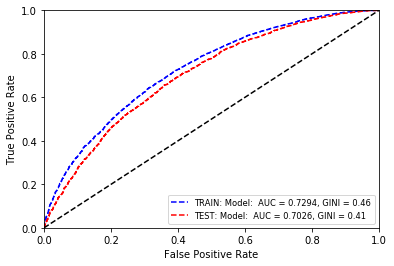

In [91]:
X_train_3['Prop'] = clf3.predict(X_train_3, prediction_type="Probability")[:, 1]
X_test_3['Prop'] = clf3.predict(X_test_3, prediction_type="Probability")[:, 1]

gini_train_3 = 2 * roc_auc_score(y_train_3, X_train_3['Prop']) - 1
gini_test_3 = 2 * roc_auc_score(y_test_3, X_test_3['Prop']) - 1
print('gini train = %s, gini test = %s' % (gini_train_3, gini_test_3))

plot_roc_curve(y_train_3, X_train_3['Prop'], gini_train_3, y_test_3, X_test_3['Prop'], gini_test_3)

## Financed top 70

gini train = 0.4568563646696888, gini test = 0.4135964766025997


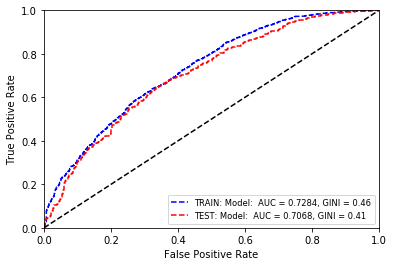

In [93]:
train_4 = df[(df['SampleType'] == 'train') & (df['Financed'] == 1)].copy()
test_4 = df[(df['SampleType'] == 'test') & (df['Financed'] == 1)].copy()

X_train_4 = train_4.loc[:, all_features_3]
y_train_4 = train_4[target]

X_test_4 = test_4.loc[:, all_features_3]
y_test_4 = test_4[target]

X_train_4['Prop'] = clf3.predict(X_train_4, prediction_type="Probability")[:, 1]
X_test_4['Prop'] = clf3.predict(X_test_4, prediction_type="Probability")[:, 1]

gini_train_4 = 2 * roc_auc_score(y_train_4, X_train_4['Prop']) - 1
gini_test_4 = 2 * roc_auc_score(y_test_4, X_test_4['Prop']) - 1
print('gini train = %s, gini test = %s' % (gini_train_4, gini_test_4))

plot_roc_curve(y_train_4, X_train_4['Prop'], gini_train_4, y_test_4, X_test_4['Prop'], gini_test_4)

## Mean scores, bad rates

In [101]:
X_train_5 = X_train_4.copy()
X_train_5['sample'] = 'train'

X_test_5 = X_test_4.copy()
X_test_5['sample'] = 'test'

X_all = pd.concat([X_train_5, X_test_5], axis=0)
y_all = pd.concat([y_train_4, y_test_4], axis=0)
data_all = pd.concat([X_all, y_all], axis=1)
data_all['q'] = pd.qcut(data_all['Prop'], 10)

In [102]:
data_all.head()

,var_03_queries_1m,scorecard_13_14,MIGCREDIT_SCORE,Var__appl_00059,var_03_queries_3m,var_03_queries_2m,var_03_queries_6m,var_03_queries_14d,Var_online_00011,var_03_queries_24m,...,Var_00121,Var_00052,Var__appl_00019,Var_00068,Var_00003,Var_00253,Prop,sample,target,q
1,0.0,612.0,0.328292,2.0,3.0,0.0,3.0,0.0,-1.0,3.0,...,-1.0,0.0,20000.0,0.0,0.0,5459.0,0.339156,train,0,"(0.297, 0.374]"
11,2.0,611.0,0.322402,47.0,10.0,6.0,11.0,1.0,2.0,11.0,...,4.0,0.0,0.0,0.0,7.0,77817.0,0.363643,train,0,"(0.297, 0.374]"
21,0.0,693.0,0.240549,119.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,2.0,0.0,0.0,0.0,4.0,148489.0,0.342384,train,1,"(0.297, 0.374]"
22,0.0,531.0,0.303162,106.0,1.0,0.0,5.0,0.0,-1.0,20.0,...,12.0,46900.0,4500.0,2365.0,13.0,19075.0,0.465884,train,0,"(0.431, 0.484]"
29,8.0,450.0,0.470832,144.0,11.0,10.0,12.0,6.0,6.0,14.0,...,3.0,0.0,30000.0,0.0,5.0,176454.0,0.743545,train,1,"(0.701, 0.755]"


                         target      Prop
                           mean      mean
sample q                                 
test   (0.106, 0.297]  0.110294  0.238999
       (0.297, 0.374]  0.300000  0.334376
       (0.374, 0.431]  0.352941  0.400593
       (0.431, 0.484]  0.414634  0.457960
       (0.484, 0.542]  0.415385  0.513508
       (0.542, 0.596]  0.508475  0.567648
       (0.596, 0.646]  0.600000  0.620953
       (0.646, 0.701]  0.557143  0.675236
       (0.701, 0.755]  0.730000  0.727967
       (0.755, 0.896]  0.717557  0.792150
train  (0.106, 0.297]  0.079681  0.234128
       (0.297, 0.374]  0.237354  0.337738
       (0.374, 0.431]  0.373134  0.405401
       (0.431, 0.484]  0.462121  0.455445
       (0.484, 0.542]  0.494163  0.514379
       (0.542, 0.596]  0.483271  0.568348
       (0.596, 0.646]  0.580153  0.619376
       (0.646, 0.701]  0.623482  0.673212
       (0.701, 0.755]  0.675958  0.728501
       (0.755, 0.896]  0.824219  0.788503


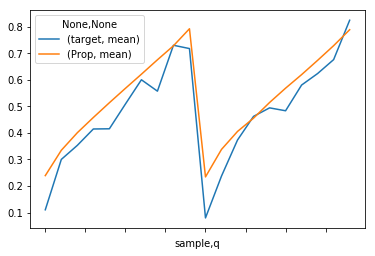

In [109]:
data_all.groupby(['sample', 'q']).agg({target: [np.mean], 'Prop': np.mean}).plot()
print(stat)

## Boosting interpretation

In [111]:
import shap

In [119]:
numeric_features_indexes = list(np.where(pd.concat([X_train_3, X_test_3], axis=0).dtypes == np.float)[0])
numeric_features = [list(X_train_3.columns)[i] for i in numeric_features_indexes]
numeric_features.remove('Prop')

pool_train_shap = Pool(X_train_3.loc[:, numeric_features], y_train_3)

clf_shap = CatBoostClassifier(random_seed=42, eval_metric="AUC", iterations=1000, learning_rate=0.01)
clf_shap.fit(pool_train_shap, eval_set=(X_test_3.loc[:, numeric_features], y_test_3), plot=True, verbose_eval=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6257497	best: 0.6257497 (0)	total: 33.6ms	remaining: 33.6s
1:	test: 0.6555010	best: 0.6555010 (1)	total: 64.5ms	remaining: 32.2s
2:	test: 0.6666417	best: 0.6666417 (2)	total: 96.2ms	remaining: 32s
3:	test: 0.6755744	best: 0.6755744 (3)	total: 128ms	remaining: 31.8s
4:	test: 0.6783017	best: 0.6783017 (4)	total: 162ms	remaining: 32.2s
5:	test: 0.6781051	best: 0.6783017 (4)	total: 192ms	remaining: 31.9s
6:	test: 0.6800098	best: 0.6800098 (6)	total: 224ms	remaining: 31.8s
7:	test: 0.6799470	best: 0.6800098 (6)	total: 255ms	remaining: 31.6s
8:	test: 0.6804261	best: 0.6804261 (8)	total: 285ms	remaining: 31.4s
9:	test: 0.6800888	best: 0.6804261 (8)	total: 317ms	remaining: 31.4s
10:	test: 0.6804140	best: 0.6804261 (8)	total: 346ms	remaining: 31.1s
11:	test: 0.6802995	best: 0.6804261 (8)	total: 379ms	remaining: 31.2s
12:	test: 0.6797681	best: 0.6804261 (8)	total: 410ms	remaining: 31.2s
13:	test: 0.6796071	best: 0.6804261 (8)	total: 444ms	remaining: 31.3s
14:	test: 0.6789140	best: 0.6

116:	test: 0.6875709	best: 0.6875906 (111)	total: 3.92s	remaining: 29.6s
117:	test: 0.6877201	best: 0.6877201 (117)	total: 3.95s	remaining: 29.5s
118:	test: 0.6877055	best: 0.6877201 (117)	total: 3.98s	remaining: 29.5s
119:	test: 0.6876099	best: 0.6877201 (117)	total: 4.01s	remaining: 29.4s
120:	test: 0.6876906	best: 0.6877201 (117)	total: 4.04s	remaining: 29.4s
121:	test: 0.6877728	best: 0.6877728 (121)	total: 4.08s	remaining: 29.3s
122:	test: 0.6878059	best: 0.6878059 (122)	total: 4.11s	remaining: 29.3s
123:	test: 0.6879394	best: 0.6879394 (123)	total: 4.14s	remaining: 29.2s
124:	test: 0.6880021	best: 0.6880021 (124)	total: 4.17s	remaining: 29.2s
125:	test: 0.6880867	best: 0.6880867 (125)	total: 4.2s	remaining: 29.1s
126:	test: 0.6880941	best: 0.6880941 (126)	total: 4.23s	remaining: 29.1s
127:	test: 0.6880772	best: 0.6880941 (126)	total: 4.26s	remaining: 29s
128:	test: 0.6882826	best: 0.6882826 (128)	total: 4.29s	remaining: 29s
129:	test: 0.6883372	best: 0.6883372 (129)	total: 4.32s	

229:	test: 0.6934919	best: 0.6934919 (229)	total: 7.55s	remaining: 25.3s
230:	test: 0.6936158	best: 0.6936158 (230)	total: 7.58s	remaining: 25.2s
231:	test: 0.6936558	best: 0.6936558 (231)	total: 7.61s	remaining: 25.2s
232:	test: 0.6936262	best: 0.6936558 (231)	total: 7.64s	remaining: 25.2s
233:	test: 0.6936573	best: 0.6936573 (233)	total: 7.67s	remaining: 25.1s
234:	test: 0.6936627	best: 0.6936627 (234)	total: 7.7s	remaining: 25.1s
235:	test: 0.6936429	best: 0.6936627 (234)	total: 7.73s	remaining: 25s
236:	test: 0.6936749	best: 0.6936749 (236)	total: 7.77s	remaining: 25s
237:	test: 0.6936915	best: 0.6936915 (237)	total: 7.8s	remaining: 25s
238:	test: 0.6937392	best: 0.6937392 (238)	total: 7.83s	remaining: 24.9s
239:	test: 0.6937176	best: 0.6937392 (238)	total: 7.87s	remaining: 24.9s
240:	test: 0.6937947	best: 0.6937947 (240)	total: 7.91s	remaining: 24.9s
241:	test: 0.6938384	best: 0.6938384 (241)	total: 7.94s	remaining: 24.9s
242:	test: 0.6938745	best: 0.6938745 (242)	total: 7.97s	rem

342:	test: 0.6966088	best: 0.6966088 (342)	total: 11.1s	remaining: 21.3s
343:	test: 0.6966055	best: 0.6966088 (342)	total: 11.2s	remaining: 21.3s
344:	test: 0.6966328	best: 0.6966328 (344)	total: 11.2s	remaining: 21.2s
345:	test: 0.6966411	best: 0.6966411 (345)	total: 11.2s	remaining: 21.2s
346:	test: 0.6967132	best: 0.6967132 (346)	total: 11.2s	remaining: 21.2s
347:	test: 0.6967196	best: 0.6967196 (347)	total: 11.3s	remaining: 21.1s
348:	test: 0.6967070	best: 0.6967196 (347)	total: 11.3s	remaining: 21.1s
349:	test: 0.6966857	best: 0.6967196 (347)	total: 11.3s	remaining: 21.1s
350:	test: 0.6966929	best: 0.6967196 (347)	total: 11.4s	remaining: 21s
351:	test: 0.6967233	best: 0.6967233 (351)	total: 11.4s	remaining: 21s
352:	test: 0.6968128	best: 0.6968128 (352)	total: 11.4s	remaining: 21s
353:	test: 0.6968826	best: 0.6968826 (353)	total: 11.5s	remaining: 20.9s
354:	test: 0.6968698	best: 0.6968826 (353)	total: 11.5s	remaining: 20.9s
355:	test: 0.6968586	best: 0.6968826 (353)	total: 11.5s	r

455:	test: 0.6985399	best: 0.6985399 (455)	total: 14.7s	remaining: 17.6s
456:	test: 0.6985502	best: 0.6985502 (456)	total: 14.8s	remaining: 17.5s
457:	test: 0.6985580	best: 0.6985580 (457)	total: 14.8s	remaining: 17.5s
458:	test: 0.6985490	best: 0.6985580 (457)	total: 14.8s	remaining: 17.5s
459:	test: 0.6985478	best: 0.6985580 (457)	total: 14.9s	remaining: 17.5s
460:	test: 0.6985307	best: 0.6985580 (457)	total: 14.9s	remaining: 17.4s
461:	test: 0.6986002	best: 0.6986002 (461)	total: 14.9s	remaining: 17.4s
462:	test: 0.6986256	best: 0.6986256 (462)	total: 15s	remaining: 17.4s
463:	test: 0.6986756	best: 0.6986756 (463)	total: 15s	remaining: 17.3s
464:	test: 0.6986553	best: 0.6986756 (463)	total: 15s	remaining: 17.3s
465:	test: 0.6986449	best: 0.6986756 (463)	total: 15.1s	remaining: 17.3s
466:	test: 0.6986489	best: 0.6986756 (463)	total: 15.1s	remaining: 17.2s
467:	test: 0.6987064	best: 0.6987064 (467)	total: 15.1s	remaining: 17.2s
468:	test: 0.6987168	best: 0.6987168 (468)	total: 15.2s	r

568:	test: 0.6999374	best: 0.6999415 (567)	total: 18.4s	remaining: 13.9s
569:	test: 0.6999319	best: 0.6999415 (567)	total: 18.4s	remaining: 13.9s
570:	test: 0.6999823	best: 0.6999823 (570)	total: 18.5s	remaining: 13.9s
571:	test: 0.6999902	best: 0.6999902 (571)	total: 18.5s	remaining: 13.8s
572:	test: 0.7000045	best: 0.7000045 (572)	total: 18.5s	remaining: 13.8s
573:	test: 0.7000103	best: 0.7000103 (573)	total: 18.6s	remaining: 13.8s
574:	test: 0.7000491	best: 0.7000491 (574)	total: 18.6s	remaining: 13.7s
575:	test: 0.7000859	best: 0.7000859 (575)	total: 18.6s	remaining: 13.7s
576:	test: 0.7001469	best: 0.7001469 (576)	total: 18.7s	remaining: 13.7s
577:	test: 0.7001503	best: 0.7001503 (577)	total: 18.7s	remaining: 13.6s
578:	test: 0.7001711	best: 0.7001711 (578)	total: 18.7s	remaining: 13.6s
579:	test: 0.7002096	best: 0.7002096 (579)	total: 18.8s	remaining: 13.6s
580:	test: 0.7002127	best: 0.7002127 (580)	total: 18.8s	remaining: 13.5s
581:	test: 0.7002024	best: 0.7002127 (580)	total: 1

681:	test: 0.7011310	best: 0.7011310 (681)	total: 22s	remaining: 10.3s
682:	test: 0.7011488	best: 0.7011488 (682)	total: 22s	remaining: 10.2s
683:	test: 0.7011552	best: 0.7011552 (683)	total: 22.1s	remaining: 10.2s
684:	test: 0.7011269	best: 0.7011552 (683)	total: 22.1s	remaining: 10.2s
685:	test: 0.7011346	best: 0.7011552 (683)	total: 22.1s	remaining: 10.1s
686:	test: 0.7011401	best: 0.7011552 (683)	total: 22.2s	remaining: 10.1s
687:	test: 0.7011407	best: 0.7011552 (683)	total: 22.2s	remaining: 10.1s
688:	test: 0.7011489	best: 0.7011552 (683)	total: 22.2s	remaining: 10s
689:	test: 0.7011322	best: 0.7011552 (683)	total: 22.2s	remaining: 9.99s
690:	test: 0.7011328	best: 0.7011552 (683)	total: 22.3s	remaining: 9.96s
691:	test: 0.7011354	best: 0.7011552 (683)	total: 22.3s	remaining: 9.93s
692:	test: 0.7011444	best: 0.7011552 (683)	total: 22.3s	remaining: 9.9s
693:	test: 0.7011666	best: 0.7011666 (693)	total: 22.4s	remaining: 9.87s
694:	test: 0.7011660	best: 0.7011666 (693)	total: 22.4s	re

794:	test: 0.7021677	best: 0.7021753 (788)	total: 25.8s	remaining: 6.65s
795:	test: 0.7021885	best: 0.7021885 (795)	total: 25.8s	remaining: 6.62s
796:	test: 0.7021810	best: 0.7021885 (795)	total: 25.9s	remaining: 6.59s
797:	test: 0.7021833	best: 0.7021885 (795)	total: 25.9s	remaining: 6.56s
798:	test: 0.7021948	best: 0.7021948 (798)	total: 26s	remaining: 6.53s
799:	test: 0.7021902	best: 0.7021948 (798)	total: 26s	remaining: 6.5s
800:	test: 0.7022238	best: 0.7022238 (800)	total: 26s	remaining: 6.47s
801:	test: 0.7022287	best: 0.7022287 (801)	total: 26.1s	remaining: 6.43s
802:	test: 0.7022158	best: 0.7022287 (801)	total: 26.1s	remaining: 6.4s
803:	test: 0.7022140	best: 0.7022287 (801)	total: 26.1s	remaining: 6.37s
804:	test: 0.7022186	best: 0.7022287 (801)	total: 26.2s	remaining: 6.34s
805:	test: 0.7022561	best: 0.7022561 (805)	total: 26.2s	remaining: 6.3s
806:	test: 0.7022502	best: 0.7022561 (805)	total: 26.2s	remaining: 6.27s
807:	test: 0.7022707	best: 0.7022707 (807)	total: 26.3s	rema

907:	test: 0.7030061	best: 0.7030173 (906)	total: 29.6s	remaining: 2.99s
908:	test: 0.7030028	best: 0.7030173 (906)	total: 29.6s	remaining: 2.96s
909:	test: 0.7029903	best: 0.7030173 (906)	total: 29.6s	remaining: 2.93s
910:	test: 0.7029803	best: 0.7030173 (906)	total: 29.7s	remaining: 2.9s
911:	test: 0.7029871	best: 0.7030173 (906)	total: 29.7s	remaining: 2.86s
912:	test: 0.7030118	best: 0.7030173 (906)	total: 29.7s	remaining: 2.83s
913:	test: 0.7030124	best: 0.7030173 (906)	total: 29.8s	remaining: 2.8s
914:	test: 0.7030274	best: 0.7030274 (914)	total: 29.8s	remaining: 2.77s
915:	test: 0.7030226	best: 0.7030274 (914)	total: 29.8s	remaining: 2.73s
916:	test: 0.7030225	best: 0.7030274 (914)	total: 29.8s	remaining: 2.7s
917:	test: 0.7030175	best: 0.7030274 (914)	total: 29.9s	remaining: 2.67s
918:	test: 0.7029960	best: 0.7030274 (914)	total: 29.9s	remaining: 2.63s
919:	test: 0.7030319	best: 0.7030319 (919)	total: 30s	remaining: 2.6s
920:	test: 0.7030441	best: 0.7030441 (920)	total: 30s	rem

In [120]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf_shap)
shap_values = explainer.shap_values(X_train_3.loc[:, numeric_features])

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], numeric_features)

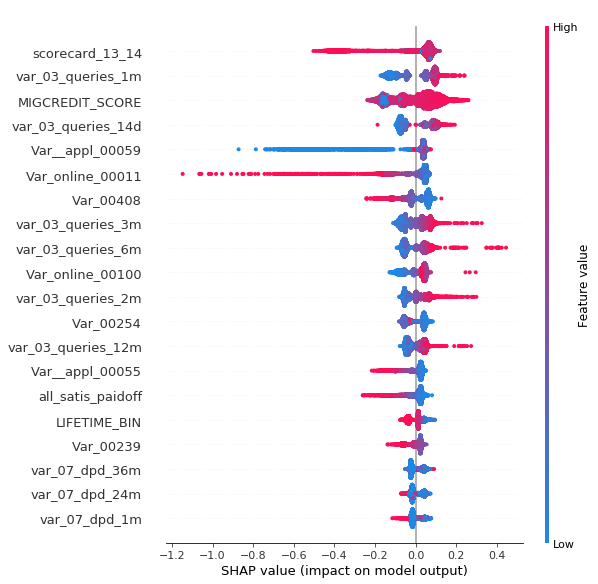

In [121]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train_3.loc[:, numeric_features])